# UK rivers catchment map
Inspired by the really cool catchments maps they make at Grasshopper Geography:  
https://www.grasshoppergeography.com/River-Maps/  
I wanted to see if I could come up with something along the same lines. In the UK the Ordnance Survey has produced and made publicly available a shapefile for all watercourses of the UK except Northern Ireland. It can be found here:  
https://www.ordnancesurvey.co.uk/business-government/products/open-map-rivers

###### Import modules

In [1]:
# Import required modules
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Read in watercourse shp file
gdf = gpd.read_file(r'C:\Users\sgibs\Documents\Datasets\os_open_rivers\WatercourseLink.shp')

In [3]:
# What do we have?
print(gdf.shape)
print(gdf.crs)
gdf.head(2)

(187356, 10)
epsg:27700


,name1,identifier,startNode,endNode,form,flow,fictitious,length,name2,geometry
0,None,80663CF2-287A-4A84-8019-6307CCF3C5AE,C9EE15CE-0809-4AD6-8161-D62476ED2545,DCA23AF5-A05D-400F-9F3C-FD9B762FAFAC,inlandRiver,in direction,false,79,None,"LINESTRING Z (459018.230 1214628.440 0.000, 45..."
1,None,E72C2FDE-509C-45B0-8CAC-7119C479B341,DCA23AF5-A05D-400F-9F3C-FD9B762FAFAC,4DB9A050-40E9-4F6B-946E-9CC78808345C,lake,in direction,false,33,None,"LINESTRING Z (459077.000 1214575.500 0.000, 45..."


* Gdf contains many ~190,000 individual linestring geometries
* Watercourses are made up of a series of linestrings
* _Some_ linestrings are labelled with river name, but not many
* Majority are of form 'inlandRiver', but also includes tidal river, canal and lake

In [4]:
# Interested in catchment watercourses so drop canals
gdf = gdf.drop(gdf[gdf['form']=='canal'].index)
print(gdf.shape)

(186100, 10)


Including tidal rivers has the impact of merging many different catchments into a much smaller number. For instance combining the Trent and the Ouse together at the Humber. Although removing the tidal rivers can also obscure things in a few locations by preventing a number of catchments from joining

In [5]:
# After testing with and without, drop tidal rivers
gdf = gdf.drop(gdf[gdf['form']=='tidalRiver'].index)
print(gdf.shape)

(175877, 10)


One of the main difficulties I found with my process was the long time needed to run a number of my functions due to the very large dataset involved. It was much easier to test using a subset

In [6]:
# Take a subset of dataset using geo info
wales = gdf.cx[160000:360000,160000:390000]
# How much smaller is our subset?
print(wales.shape)

(27010, 10)


### Define processing functions

Initially tried to merge touching linestrings to form overall catchments. However there are gaps or missing geometry, which resulted in very few connected geometries. My solution was to buffer the linestrings and merge the resulting polygons. The increased thickness produced overlapping geometries which could be merged.

In [7]:
def bufferUnion(gdf, size=50):
    """
    buffers gdf geometries and merges all geometries
    prints original number of linestrings and number of new merged polygons
    
    Parameters
    ----------
    gdf : geodataframe
        gdf containing catchment geometries
    
    size : int
        buffer thickness
        
    Returns
    -------
    union : 
    """
    gdfBuffer = gdf.buffer(size)
    union = gdfBuffer.unary_union
    print('{} elements reduced to {}'.format(gdf.shape[0], len(union)))
    return union    

In [8]:
def rebuildGeo(union, crs=gdf.crs):
    """
    creates a geodataframe from single geometry object
    splits individual geometries (multi polygons) into individual catchment objects (merged polygons)
    reassigns a crs to geometries
    
    Parameters
    ----------
    union : single geometry object
        object contains multiple merged overlapping polygons
        
    crs : coordinate reference system string identifier
        default = gdf.crs
        crs to rebuild gdf geometry
        
    Returns
    -------
    gdf : geodataframe
        contains rebuilt geometries per row
    """
    series = pd.Series(union)
    gdf = gpd.GeoDataFrame(series)
    gdf = gdf.rename({0:'geometry'}, axis =1)
    gdf = gdf.set_geometry(col='geometry')
    gdf = gdf.reset_index(drop=True)
    gdf = gdf.set_crs(crs)
    return gdf    

In [9]:
def bufferPlot(gdf, size=200):
    """
    buffers gdf geometry by size for use when plotting
    
    Parameters
    ----------
    gdf : geodataframe
        gdf containing geometry to buffer
        
    size : int
        default = 200
        size to buffer geometry by        
        
    Returns
    -------
    gdf : geodataframe
        contains buffered geometries
    """
    gdf = gdf.buffer(size)
    return gdf

In [10]:
def addHullsAreaCentrGeo(gdf):
    """
    adds convex hull and centroid geometries to gdf
    calculates convex hull area
    
    Parameters
    ----------
    gdf : geodataframe
        gdf to add columns to
        
    Returns
    -------
    gdf : geodataframe
        gdf containing additional columns
    """
    gdf['hullGeometry'] = gdf['geometry'].convex_hull
    gdf['hullArea'] = gdf.set_geometry(col='hullGeometry').area
    gdf['centroidGeometry'] = gdf.set_geometry(col='hullGeometry').centroid
    return gdf

In [11]:
def areaFilter(gdf, areaThreshold = 1e7):
    """
    removes rows from gdf with convex hull geometries of area less than the area threshold
    
    Parameters
    ----------
    gdf : geodataframe
        gdf from which to remove geometries
    
    areaThreshold : int
        default = 1e7
        minimum area for convex hull geometries in returned gdf
        
    Returns
    -------
    gdf : geodataframe
        original gdf with convex hull geometry areas above areaThreshold
    """
    indexDrop = gdf[gdf['hullArea'] < areaThreshold].index
    print('For area threshold of {}m^2:\n{} rows remaining from {}'.format(areaThreshold,len(gdf)-len(indexDrop),len(gdf)))
    return gdf.drop(indexDrop)

### Processing
###### Care - long time to execute depending on size of input

In [12]:
# Create union object
union = bufferUnion(wales)

27010 elements reduced to 765


###### Care - long time to execute:

In [13]:
# Rebuild geometry
gdfUnion = rebuildGeo(union)

In [ ]:
# Save merged and rebuilt geometry to file
#gdfUnion.to_file('OSOpenRivers/catchments.shp', driver = 'ESRI Shapefile', encoding='utf-8')

In [14]:
# Add convex hull and centroid geometries and calculate convex hull area variable
gdfPlot = addHullsAreaCentrGeo(gdfUnion)

In [15]:
# Use convex hull areas to remove small catchments
gdfPlot = areaFilter(gdfPlot, areaThreshold = 1e6)

For area threshold of 1000000.0m^2:
301 rows remaining from 765


###### Care - long time to execute:

In [16]:
# Buffer catchment geometry for plotting
gdfPlot['geometryBuff'] = bufferPlot(gdfPlot)

A key difficulty when plotting the final catchments was the issue of adjacent geometries plotting in the same colour. To try and address this I labelled each catchment with random integer 0-9 and plotted this as a categorical variable. There is still a significant chance of adjacent catchments sharing the same random label.

In [17]:
# Assign random integer label to each row
gdfPlot['rand'] = np.random.randint(0,10,size=len(gdfPlot))

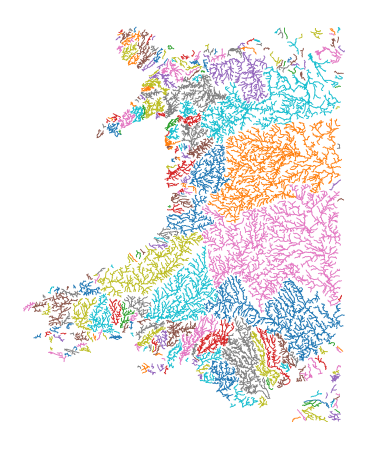

In [18]:
# Figure for plotting catchment map
fig, ax = plt.subplots(figsize=(8,8))

#gdfPlot.set_geometry('centroidGeometry').plot(ax=ax,
#gdfPlot.set_geometry('hullGeometry').plot(ax=ax,
gdfPlot.set_geometry('geometryBuff').plot(ax=ax,
                  column='rand',
                  #categorical=True,
                  cmap='tab10')

# Remove map axes
ax.set_axis_off()

# Save file, high dpi for printing
plt.savefig('OSOpenRivers/catchments.png', dpi=500)

### Result
The final result shown here for catchments of Wales is good overall. There are many small catchments along the coast and most of the bigger rivers seem to be correctly identified. The Wye is split across several catchments because the point at which they meet is outside of this map.

Problems include the long processing time, particularly for the map of the whole UK. Also the choice of whether to include the tidal rivers is not clear cut - in some areas it would be more representative to keep them in to merge some smaller catchments nearer the coast. In some locations on the UK map it could be seen that catchments had merged incorrectly, this could be a result of very close geometries which incorrectly overlap once they were buffered.

Overall this was an interesting exercise to try and produce some cool maps. It gave me more understanding behind some of the geometry and shapely functionality and methods. For anyone interested in these types of maps, I strongly recommend having a look at Grasshopper Geography's website and the great stuff they produce.